## RoBERTa (Robustly Optimized BERT Approach)

####
RoBERTa is an advanced language model that builds upon BERT by optimizing training methods, such as removing the next-sentence prediction task, using larger datasets, dynamic masking, and increased training time. It excels at capturing contextual word representations, making it highly effective for natural language processing tasks like text classification. To build a classifier, RoBERTa is fine-tuned on a labeled dataset where its output embeddings (contextual word representations) are passed to a fully connected layer to predict class labels. UMAP (Uniform Manifold Approximation and Projection) complements this by reducing the dimensionality of RoBERTa's high-dimensional embeddings for visualization or clustering, revealing patterns in the data while maintaining its structure.

In [35]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import nltk
import string
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.manifold import TSNE
import umap

In [14]:
df_rtr = pd.read_json("data/renttherunway_final_data.json", lines=True)
df_rtr.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [29]:
# Select necessary columns and drop NaN
df = df_rtr[['fit', 'review_text']].dropna()

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stop words
    return text

# Apply preprocessing
df['review_text'] = df['review_text'].apply(preprocess)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katyatalipova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
df.head()

,fit,review_text
0,fit,adorable romper belt zipper little hard naviga...
1,fit,rented dress photo shoot theme hollywood glam ...
2,fit,hugged right places perfect dress event receiv...
3,fit,rented companys black tie awards banquet liked...
4,fit,always petite upper body extremely athletic im...


In [31]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['review_text'])

In [32]:
# Target variable
y = df['fit']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         fit       0.78      0.99      0.87     28278
       large       0.85      0.24      0.37      5008
       small       0.85      0.20      0.32      5223

    accuracy                           0.79     38509
   macro avg       0.83      0.48      0.52     38509
weighted avg       0.80      0.79      0.73     38509



## RoBERTA

In [36]:
# Load RoBERTA model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Function to get embeddings from RoBERTA
def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    # Average token embeddings (hidden states) to get a single vector
    embedding = output.last_hidden_state.mean(dim=1).squeeze(0).numpy()
    return embedding

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Apply RoBERTA to the dataset

In [37]:
# Generate embeddings for all reviews
df['embedding'] = df['review_text'].apply(get_embedding)

# Convert embeddings to a matrix
X_embeddings = np.vstack(df['embedding'].values)

#### Dimensionality Reduction for Visualization

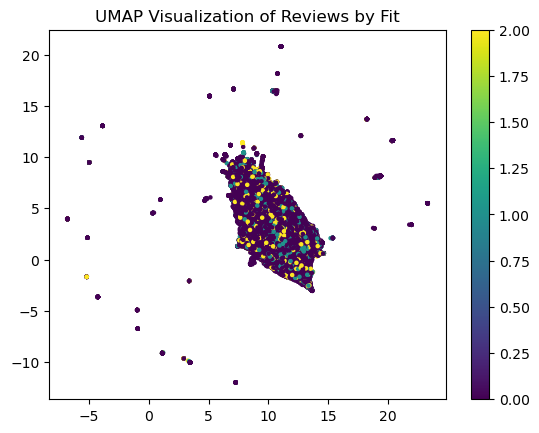

In [38]:
# Using UMAP (or replace with TSNE for comparison)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
X_reduced = reducer.fit_transform(X_embeddings)

# Plot UMAP visualization
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['fit'].factorize()[0], cmap='viridis', s=5)
plt.colorbar()
plt.title("UMAP Visualization of Reviews by Fit")
plt.show()

#### This visualization is a UMAP plot representing the semantic relationships of the reviews based on their RoBERTA-generated embeddings, with the color coding corresponding to the "fit" variable.

**Interpretation**:
- Clusters:
Points that are close together represent reviews with similar semantic meanings. For example, reviews describing tight fits may cluster together, and reviews about oversized fits may form another group.
- Color Gradient:
The color bar (ranging from 0 to 2) indicates the "fit" categories:
0 might represent "Small/Tight fit."
1 could represent "True to size."
2 might indicate "Large/Oversized fit."
You can infer how well-separated these categories are. If distinct color groups exist, the embeddings capture meaningful differences related to the fit.
- Dense vs Sparse Areas:
The dense region in the middle suggests that most reviews are semantically similar, possibly because "fit" reviews often use similar vocabulary.
The outliers (points far from the dense cluster) might correspond to unusual reviews or edge cases.
- Insights for Classification:
If there’s overlap between colors, the fit categories may share overlapping language (e.g., "tight" might also appear in reviews for "oversized" if the context is unclear).
Better separation between colors suggests that a classifier can effectively distinguish between categories using the embeddings.


#### Use embeddings to train a classifier

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Concatenate embeddings and any additional features (if any)
X = X_embeddings  # Add other features if required
y = df['fit']

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         fit       0.74      1.00      0.85     28278
       large       0.65      0.02      0.04      5008
       small       0.56      0.03      0.05      5223

    accuracy                           0.74     38509
   macro avg       0.65      0.35      0.31     38509
weighted avg       0.70      0.74      0.64     38509

